In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import models
import build

In [2]:
base, trainable = models.ResNet50()

In [3]:
dataset, n = datasets.SCUTFBP5500(
    input_shape=base.input_shape,
    #features="./14x14/"
)

#dataset, n = datasets.MEBeauty(
    #ratings="./MEBeauty_Distribution2.csv",
    #input_shape=base.input_shape
#)

dataset.generate(model=base, out_path="/14x14/", augment=0)

69/69 [==============================] - 1s 20ms/step
(3300, 14, 14, 1024) (2200, 14, 14, 1024)
(3300, 5) (2200, 5)
Train generator saved to c:\Users\ugail\Documents\research/14x14/train.pkl
Test generator saved to c:\Users\ugail\Documents\research/14x14/test.pkl


In [4]:
#If mlp_weights not specified it will return just the mlp
model = build.build(
    base.output_shape,
    trainable=trainable,
    n=n,
    mlp_weights="./mlp.hdf5",
    augment=False,
)

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1, 2048)]      0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                               

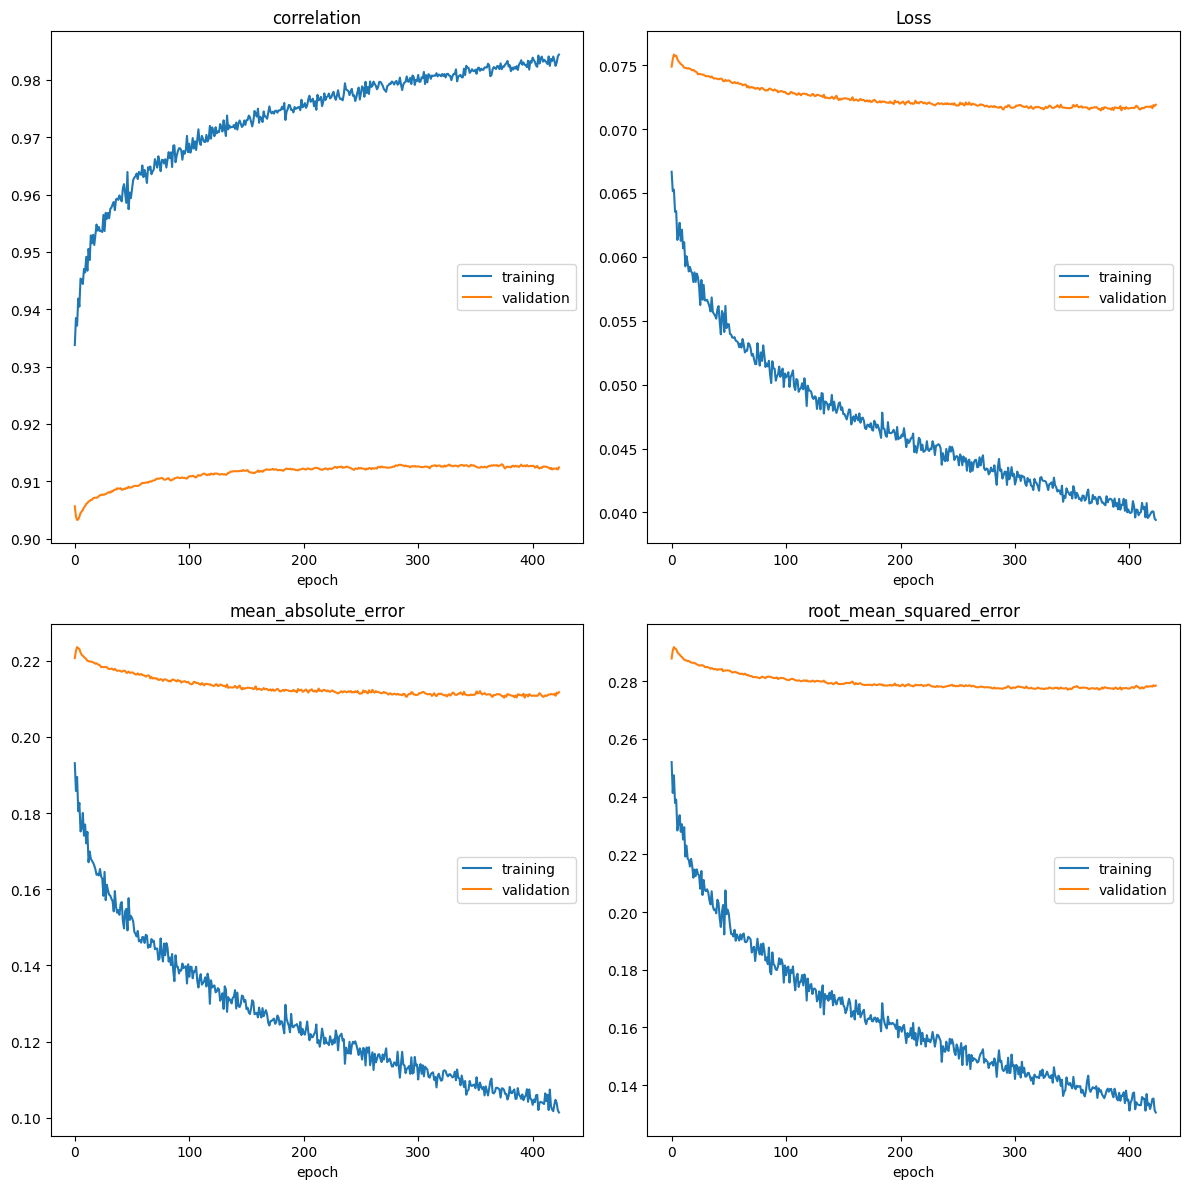

correlation
	training         	 (min:    0.934, max:    0.984, cur:    0.984)
	validation       	 (min:    0.903, max:    0.913, cur:    0.912)
Loss
	training         	 (min:    0.039, max:    0.067, cur:    0.039)
	validation       	 (min:    0.071, max:    0.076, cur:    0.072)
mean_absolute_error
	training         	 (min:    0.101, max:    0.193, cur:    0.101)
	validation       	 (min:    0.210, max:    0.224, cur:    0.212)
root_mean_squared_error
	training         	 (min:    0.131, max:    0.252, cur:    0.131)
	validation       	 (min:    0.277, max:    0.292, cur:    0.278)
104/104 [==============================] - 3s 26ms/step - loss: 0.0394 - mean_absolute_error: 0.1014 - root_mean_squared_error: 0.1305 - correlation: 0.9844 - val_loss: 0.0719 - val_mean_absolute_error: 0.2117 - val_root_mean_squared_error: 0.2785 - val_correlation: 0.9124
Time: 19.7375


In [6]:
metrics = [losses.MeanAbsoluteError(n=n),
           losses.RootMeanSquaredError(n=n),
           losses.PearsonCorrelation(n=n)]#,
           #losses.MeanAbsoluteError(n=n, mode="var"),
           #losses.RootMeanSquaredError(n=n, mode="var"),
           #losses.PearsonCorrelation(n=n, mode="var"),
           #losses.MeanAbsoluteError(n=n, mode="skew"),
           #losses.RootMeanSquaredError(n=n, mode="skew"),
           #losses.PearsonCorrelation(n=n, mode="skew")]

#loss = tf.keras.losses.MeanSquaredError()
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = losses.SquaredEarthMoversDistance()

#dataset.shuffle()
build.compile(model, loss, metrics=metrics, learning_rate=0.0001)
time = build.train(
    model, 
    dataset.train, 
    dataset.test,
    monitor="val_correlation",
    callbacks=[PlotLossesKerasTF()]
)

print(f"Time: {np.round(time, 4)}")

In [7]:
#np.round(model.evaluate(dataset.test), 6)
y_pred = model.predict(dataset.test.x)
print(metrics[0](dataset.test.y, y_pred))
print(metrics[1](dataset.test.y, y_pred))
print(metrics[2](dataset.test.y, y_pred))
#np.save("y_pred_20.npy", y_pred)

69/69 [==============================] - 1s 8ms/step
tf.Tensor(0.21052442, shape=(), dtype=float32)
tf.Tensor(0.27988246, shape=(), dtype=float32)
tf.Tensor([[0.91198206]], shape=(1, 1), dtype=float32)


In [5]:
"""
m = np.zeros(dataset.test.y.shape)

k = 15
for i in range(10):
    m += np.load(f"y_pred_2{i}.npy")
for i in range(5):
    m += np.load(f"y_pred_1{i+1}.npy")
m /= k

print(metrics[0](dataset.test.y, m))
print(metrics[1](dataset.test.y, m))
print(metrics[2](dataset.test.y, m))
"""

'\nm = np.zeros(dataset.test.y.shape)\n\nk = 15\nfor i in range(10):\n    m += np.load(f"y_pred_2{i}.npy")\nfor i in range(5):\n    m += np.load(f"y_pred_1{i+1}.npy")\nm /= k\n\nprint(metrics[0](dataset.test.y, m))\nprint(metrics[1](dataset.test.y, m))\nprint(metrics[2](dataset.test.y, m))\n'